In [1]:
#%pip install tifffile
#%pip install monai
%pip install -q git+https://github.com/huggingface/transformers.git
#%pip install -U ipywidgets==7.7.1


Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [2]:
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from scipy import ndimage
import tifffile
from torch.utils.data import DataLoader
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from transformers import SamProcessor

In [ ]:
#sidewalk_test = load_dataset("back2classroom/sidewalks", split='test', streaming=True)
#print(next(iter(sidewalk_test)))

In [3]:
test_images = tifffile.imread("/workspaces/csgy6613-project/Test/*.tif")
test_labels = tifffile.imread("/workspaces/csgy6613-project/Label/Test/*.tif")

In [4]:
test_images.shape

(20000, 256, 256, 3)

In [5]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(test_labels) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = test_images[valid_indices]
filtered_masks = test_labels[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (9383, 256, 256, 3)
Mask shape: (9383, 256, 256)


In [6]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [7]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 9383
})

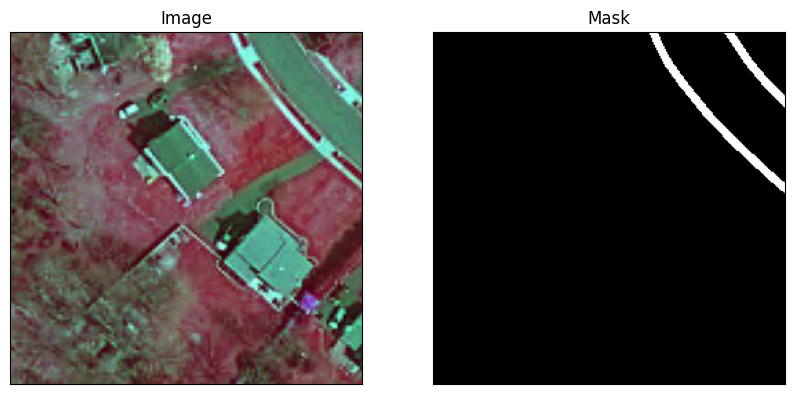

In [9]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [10]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [11]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
print()

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)